# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

#####❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

---

**ANSWER:**

We are specifically relating *the questions* to *the documents*. This means that we are making our embedding model at the very specific task of relating potential questions to specific documents.

There are many caveats, but the main ones are:

- Your Q's should reflect the Q's of your users
- This kind of fine-tuning will (purposefully) "overfit" on your data; this is the desired result in this case.

## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

>> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [ ]:
#!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

In [ ]:
#!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml 

### Provide OpenAI API Key

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [2]:
!mkdir data

In [3]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31413    0 31413    0     0  66787      0 --:--:-- --:--:-- --:--:-- 66694


In [4]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70272    0 70272    0     0  1140k      0 --:--:-- --:--:-- --:--:-- 1143k


In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

>> NOTE: You may need to run this cell twice to get it to work.

In [7]:
training_documents = text_splitter.split_documents(text_loader.load())

In [8]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [9]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [10]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [today](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [11]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [13]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [14]:
import tqdm
def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}
  for document in tqdm.tqdm(documents):
    document_content = {"context" : document.page_content, "questions" : []}
    questions_generated = question_generation_chain.invoke({"context": document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]
  return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [16]:
training_questions, training_relevant_contexts =  create_questions(training_split_documents, 2)

100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


We'll use the function to generate training, validation, and test data.

In [17]:
val_questions, val_relevant_contexts =  create_questions(val_split_documents, 2)

100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


In [18]:
test_questions, test_relevant_contexts =  create_questions(test_split_documents, 2)

100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [19]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [20]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [21]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [ ]:
#!pip install -qU sentence_transformers datasets pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
pylibcudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 1

In [22]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [23]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [24]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [25]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [26]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [27]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

$\color{blue}{\textsf{[Answer]}}$

Under the hood, MultipleNegativesRankingLoss likely calculates the cosine similarity between the query embedding and the embedding of the correct document. It also calculates the cosine similarity between the query embedding and the embeddings of all the other (negative) documents in the batch. The loss function then encourages the similarity score between the query and the correct document to be higher than the similarity scores between the query and all the incorrect documents. This is typically achieved using a softmax function or a similar mechanism to create a probability distribution over the documents, where the probability of the correct document is maximized.

MatryoshkaLoss:

MatryoshkaLoss is a bit more complex. Under the hood, it appears to be doing the following:

- Embedding Truncation: It takes the embeddings generated by the model and truncates them to different dimensionalities, as specified by the matryoshka_dims parameter. For example, if matryoshka_dims is [768, 512, 256], it will create versions of the embeddings with 768, 512, and 256 dimensions.

- Loss Calculation at Each Dimensionality: For each of these truncated embeddings, it calculates the inner_train_loss (which, in this case, is MultipleNegativesRankingLoss). This means that the model is being penalized based on its ability to rank the correct document higher than the incorrect documents at each of these dimensionalities.

- Loss Aggregation: Finally, it aggregates the losses calculated at each dimensionality into a single loss value. This could be a simple sum or a weighted sum. The aggregated loss is then used to update the model's parameters during training.

In essence, MatryoshkaLoss forces the model to learn good representations at multiple levels of detail. The higher dimensions capture more fine-grained information, while the lower dimensions capture more general information.

A short summary of the losses:

- MultipleNegativesRankingLoss:

This loss function is designed to train embeddings such that relevant pairs (e.g., question and corresponding document) have similar embeddings, while non-relevant pairs have dissimilar embeddings. It operates by treating all other documents in the batch as negative examples for a given query. The goal is to rank the positive document higher than all the negative documents.

- MatryoshkaLoss:

This loss function "wraps" another loss function (in this case, MultipleNegativesRankingLoss) and enables training embeddings at multiple dimensionalities simultaneously. The matryoshka_dimensions parameter specifies the different embedding sizes to be used. This can improve the efficiency and effectiveness of the embedding model by allowing it to learn representations at different levels of granularity. It likely works by truncating the embedding vectors to the specified dimensions and calculating the loss at each of those dimensions, then summing or averaging the losses.


Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [28]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [29]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [30]:
import wandb
wandb.init(mode="disabled")

In [31]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
16,No log,No log,0.791667,0.958333,1.000000,1.000000,0.791667,0.319444,0.200000,0.100000,0.791667,0.958333,1.000000,1.000000,0.909311,0.878472,0.878472
32,No log,No log,0.791667,0.958333,1.000000,1.000000,0.791667,0.319444,0.200000,0.100000,0.791667,0.958333,1.000000,1.000000,0.909311,0.878472,0.878472
48,No log,No log,0.791667,1.000000,1.000000,1.000000,0.791667,0.333333,0.200000,0.100000,0.791667,1.000000,1.000000,1.000000,0.912200,0.881944,0.881944
50,No log,No log,0.791667,1.000000,1.000000,1.000000,0.791667,0.333333,0.200000,0.100000,0.791667,1.000000,1.000000,1.000000,0.912200,0.881944,0.881944
64,No log,No log,0.791667,0.916667,1.000000,1.000000,0.791667,0.305556,0.200000,0.100000,0.791667,0.916667,1.000000,1.000000,0.900967,0.868056,0.868056
80,No log,No log,0.791667,0.958333,1.000000,1.000000,0.791667,0.319444,0.200000,0.100000,0.791667,0.958333,1.000000,1.000000,0.898400,0.864583,0.864583
96,No log,No log,0.833333,1.000000,1.000000,1.000000,0.833333,0.333333,0.200000,0.100000,0.833333,1.000000,1.000000,1.000000,0.922122,0.895833,0.895833
100,No log,No log,0.833333,1.000000,1.000000,1.000000,0.833333,0.333333,0.200000,0.100000,0.833333,1.000000,1.000000,1.000000,0.922122,0.895833,0.895833
112,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.937500,0.916667,0.916667
128,No log,No log,0.833333,1.000000,1.000000,1.000000,0.833333,0.333333,0.200000,0.100000,0.833333,1.000000,1.000000,1.000000,0.927577,0.902778,0.902778


In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
hf_username = "philipk22"

In [34]:
model.push_to_hub(f"{hf_username}/legal-ft-2")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/philipk22/legal-ft-2/commit/a78260c1594c1df4939864920c98da7ab8e72497'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [35]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [38]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [39]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


In [40]:
te3_results_df = pd.DataFrame(te3_results)

In [41]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(1.0)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [42]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 24/24 [00:00<00:00, 87.78it/s]


In [43]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [44]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.875)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [45]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="philipk22/legal-ft-2")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at philipk22/legal-ft-2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

100%|██████████| 24/24 [00:00<00:00, 86.96it/s]


In [46]:
finetune_results_df = pd.DataFrame(finetune_results)

In [47]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(1.0)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [48]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [49]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [50]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [51]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [52]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [53]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'An agent, in the context of AI, is an infuriatingly vague term that generally refers to AI systems that can act on your behalf. There are two main interpretations: one sees agents as systems that go and perform tasks for you (like a travel agent), while the other views them as LLMs (large language models) that have access to tools and can run processes in a loop to solve problems. However, the term lacks a single, clear definition, leading to confusion about its meaning and utility.'

In [54]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu, and several others.'

In [55]:
base_rag_chain.invoke({"question" : "What is the laziest AI month?"})["response"]

'I do not know.'

In [56]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'I do not know.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [57]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [58]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [59]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'An "agent" in the context of AI refers to a system that acts on behalf of a user, but the term is vague and lacks a single, clear definition. There are different interpretations, with some viewing agents as systems that can perform tasks autonomously (like a travel agent), while others see them as LLMs (large language models) that utilize tools to solve problems. The concept is complicated by issues such as gullibility, where AI systems may believe and act on false information, limiting their effectiveness.'

In [60]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu, and several others.'

In [63]:
finetune_rag_chain.invoke({"question" : "What is the laziest AI month?"})["response"]

'I do not know.'

In [62]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The largest model that Simon has run on his phone is the Llama 3.2 3B model.'

####❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

$\color{blue}{\textsf{[Answer]}}$

The fine-tuned embedding model performed better. This is likely due to the fact that the fine-tuned model was specifically trained on the domain of legal documents, which resulted in a more accurate representation of the data.
    

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [65]:
import os
from getpass import getpass

os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")


In [66]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /home/pkang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/pkang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [85]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/home/pkang/ai/aibootcamp/AIE5/09_Finetuning_Embeddings/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/home/pkang/ai/aibootcamp/AIE5/09_Finetuning_Embeddings/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/home/pkang/ai/aibootcamp/AIE5/09_Finetuning_Embeddings/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


In [131]:
from ragas.testset import TestsetGenerator

docs = training_documents
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/83 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/127 [00:00<?, ?it/s]

Node d4346eec-1e51-493b-aa7c-15a1a4357e33 does not have a summary. Skipping filtering.
Node fed42617-62a7-4dd7-8127-c1318a5875be does not have a summary. Skipping filtering.
Node 635f105c-ff81-4e8b-b929-473c98ea81ab does not have a summary. Skipping filtering.
Node c0c4519d-e153-41c4-94d9-47cd0d19689b does not have a summary. Skipping filtering.
Node 206aac57-1fb4-464a-a200-a53ac3f3ac56 does not have a summary. Skipping filtering.
Node 6c48abdb-44ae-451a-bd3a-9e8da4ced6e3 does not have a summary. Skipping filtering.
Node 3bc803fa-3a44-4a23-b1c9-70d05650fee4 does not have a summary. Skipping filtering.
Node d2736956-1a49-4013-ba9b-1acfde075af0 does not have a summary. Skipping filtering.
Node a84f178d-eea3-4662-bb44-2f2a2ff09e7d does not have a summary. Skipping filtering.
Node 8e8dc099-8da4-41c1-ba32-20d4cd893c91 does not have a summary. Skipping filtering.
Node 37cfc304-e658-40fb-8e28-d007a841a24f does not have a summary. Skipping filtering.
Node ed4df3e3-6381-4bde-93d7-ff9af2ec2c51 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/337 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [132]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What are the key themes and pivotal moments fo...,[Things we learned about LLMs in 2024\n\n\n\n\...,The article reviews the developments in the fi...,single_hop_specifc_query_synthesizer
1,Wht is the sttus of Aple's MLX libray in the t...,[The GPT-4 barrier was comprehensively broken\...,Apple's MLX library is described as excellent ...,single_hop_specifc_query_synthesizer
2,Was a LLM traind in Chna for less than $6m?,[The rise of inference-scaling “reasoning” mod...,"Yes, the best currently available LLM was trai...",single_hop_specifc_query_synthesizer
3,Whaat is the signifiicance of GPT-4-0314 in th...,[The GPT-4 barrier was comprehensively broken\...,"GPT-4-0314, OpenAI's best model from March 202...",single_hop_specifc_query_synthesizer
4,What are the new capabilities of Gemini 1.5 Pro?,[The earliest of those was Google’s Gemini 1.5...,Gemini 1.5 Pro introduced several brand new ca...,single_hop_specifc_query_synthesizer
5,How does the training cost and performance of ...,[<1-hop>\n\nApril\n\n8th: Building files-to-pr...,"Llama 3.1 405B was trained for 30,840,000 GPU ...",multi_hop_specific_query_synthesizer
6,How have large language models evolved from be...,[<1-hop>\n\nIndustry’s Tardy Response to the A...,"In 2023, training a model that could outperfor...",multi_hop_specific_query_synthesizer
7,How does the cost-effectiveness and capabiliti...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,GPT-4o is significantly more cost-effective co...,multi_hop_specific_query_synthesizer
8,How much cheaper is GPT-4o compared to other m...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,GPT-4o is significantly cheaper compared to ot...,multi_hop_specific_query_synthesizer
9,Why GPT-4-0314 not doing so good on leaderboar...,[<1-hop>\n\nThen there’s the rest. If you brow...,GPT-4-0314 has fallen to around 70th place on ...,multi_hop_specific_query_synthesizer


In [133]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/549484b0-0e98-437f-a7b3-d8f9d29180f2


'https://app.ragas.io/dashboard/alignment/testset/549484b0-0e98-437f-a7b3-d8f9d29180f2'

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [134]:
for test_row in dataset:
  response = base_rag_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [135]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the key themes and pivotal moments fo...,"[Prompt injection explained, with video, slide...",[Things we learned about LLMs in 2024\n\n\n\n\...,The key themes and pivotal moments for LLMs in...,The article reviews the developments in the fi...,single_hop_specifc_query_synthesizer
1,Wht is the sttus of Aple's MLX libray in the t...,"[Prompt injection explained, with video, slide...",[The GPT-4 barrier was comprehensively broken\...,The status of Apple's MLX library in the tech ...,Apple's MLX library is described as excellent ...,single_hop_specifc_query_synthesizer
2,Was a LLM traind in Chna for less than $6m?,[Even the openly licensed ones are still the w...,[The rise of inference-scaling “reasoning” mod...,I do not know.,"Yes, the best currently available LLM was trai...",single_hop_specifc_query_synthesizer
3,Whaat is the signifiicance of GPT-4-0314 in th...,[That same laptop that could just about run a ...,[The GPT-4 barrier was comprehensively broken\...,I do not know.,"GPT-4-0314, OpenAI's best model from March 202...",single_hop_specifc_query_synthesizer
4,What are the new capabilities of Gemini 1.5 Pro?,[The earliest of those was Google’s Gemini 1.5...,[The earliest of those was Google’s Gemini 1.5...,The new capabilities of Gemini 1.5 Pro include...,Gemini 1.5 Pro introduced several brand new ca...,single_hop_specifc_query_synthesizer
5,How does the training cost and performance of ...,[Another common technique is to use larger mod...,[<1-hop>\n\nApril\n\n8th: Building files-to-pr...,The context provided does not contain specific...,"Llama 3.1 405B was trained for 30,840,000 GPU ...",multi_hop_specific_query_synthesizer
6,How have large language models evolved from be...,"[Prompt injection explained, with video, slide...",[<1-hop>\n\nIndustry’s Tardy Response to the A...,Large language models (LLMs) have evolved sign...,"In 2023, training a model that could outperfor...",multi_hop_specific_query_synthesizer
7,How does the cost-effectiveness and capabiliti...,[That same laptop that could just about run a ...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,The context provided indicates that GPT-4o was...,GPT-4o is significantly more cost-effective co...,multi_hop_specific_query_synthesizer
8,How much cheaper is GPT-4o compared to other m...,[That same laptop that could just about run a ...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,The provided context does not specify how much...,GPT-4o is significantly cheaper compared to ot...,multi_hop_specific_query_synthesizer
9,Why GPT-4-0314 not doing so good on leaderboar...,[That same laptop that could just about run a ...,[<1-hop>\n\nThen there’s the rest. If you brow...,The context does not provide specific informat...,GPT-4-0314 has fallen to around 70th place on ...,multi_hop_specific_query_synthesizer


In [136]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [137]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [138]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[14]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[20]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


{'context_recall': 0.1333, 'faithfulness': 0.8059, 'factual_correctness': 0.3275, 'answer_relevancy': 0.3865, 'context_entity_recall': 0.3543, 'noise_sensitivity_relevant': 0.1930}

## Test with fine-tuned embedding model

In [139]:
for test_row in dataset:
  
  response = finetune_rag_chain.invoke({"question" : test_row.eval_sample.user_input})

  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]


In [141]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the key themes and pivotal moments fo...,[Everything tagged “llms” on my blog in 2024\n...,[Things we learned about LLMs in 2024\n\n\n\n\...,The key themes and pivotal moments for LLMs in...,The article reviews the developments in the fi...,single_hop_specifc_query_synthesizer
1,Wht is the sttus of Aple's MLX libray in the t...,"[While MLX is a game changer, Apple’s own “App...",[The GPT-4 barrier was comprehensively broken\...,Apple's MLX library is considered excellent an...,Apple's MLX library is described as excellent ...,single_hop_specifc_query_synthesizer
2,Was a LLM traind in Chna for less than $6m?,"[Likewise, training. DeepSeek v3 training for ...",[The rise of inference-scaling “reasoning” mod...,I do not know.,"Yes, the best currently available LLM was trai...",single_hop_specifc_query_synthesizer
3,Whaat is the signifiicance of GPT-4-0314 in th...,[Then there’s the rest. If you browse the Chat...,[The GPT-4 barrier was comprehensively broken\...,GPT-4-0314 is significant in the context of AI...,"GPT-4-0314, OpenAI's best model from March 202...",single_hop_specifc_query_synthesizer
4,What are the new capabilities of Gemini 1.5 Pro?,[The earliest of those was Google’s Gemini 1.5...,[The earliest of those was Google’s Gemini 1.5...,The new capabilities of Gemini 1.5 Pro include...,Gemini 1.5 Pro introduced several brand new ca...,single_hop_specifc_query_synthesizer
5,How does the training cost and performance of ...,"[Likewise, training. DeepSeek v3 training for ...",[<1-hop>\n\nApril\n\n8th: Building files-to-pr...,The training cost of Llama 3.1 405B was signif...,"Llama 3.1 405B was trained for 30,840,000 GPU ...",multi_hop_specific_query_synthesizer
6,How have large language models evolved from be...,[Here’s the sequel to this post: Things we lea...,[<1-hop>\n\nIndustry’s Tardy Response to the A...,Large language models (LLMs) experienced a sig...,"In 2023, training a model that could outperfor...",multi_hop_specific_query_synthesizer
7,How does the cost-effectiveness and capabiliti...,[Today $30/mTok gets you OpenAI’s most expensi...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,GPT-4o is significantly more cost-effective th...,GPT-4o is significantly more cost-effective co...,multi_hop_specific_query_synthesizer
8,How much cheaper is GPT-4o compared to other m...,[Today $30/mTok gets you OpenAI’s most expensi...,[<1-hop>\n\nToday $30/mTok gets you OpenAI’s m...,"GPT-4o is priced at $2.50 per million tokens, ...",GPT-4o is significantly cheaper compared to ot...,multi_hop_specific_query_synthesizer
9,Why GPT-4-0314 not doing so good on leaderboar...,[That same laptop that could just about run a ...,[<1-hop>\n\nThen there’s the rest. If you brow...,GPT-4-0314 is not performing well on the leade...,GPT-4-0314 has fallen to around 70th place on ...,multi_hop_specific_query_synthesizer


In [142]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [143]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[14]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


{'context_recall': 0.7850, 'faithfulness': 0.8326, 'factual_correctness': 0.4900, 'answer_relevancy': 0.8630, 'context_entity_recall': 0.5473, 'noise_sensitivity_relevant': 0.3370}

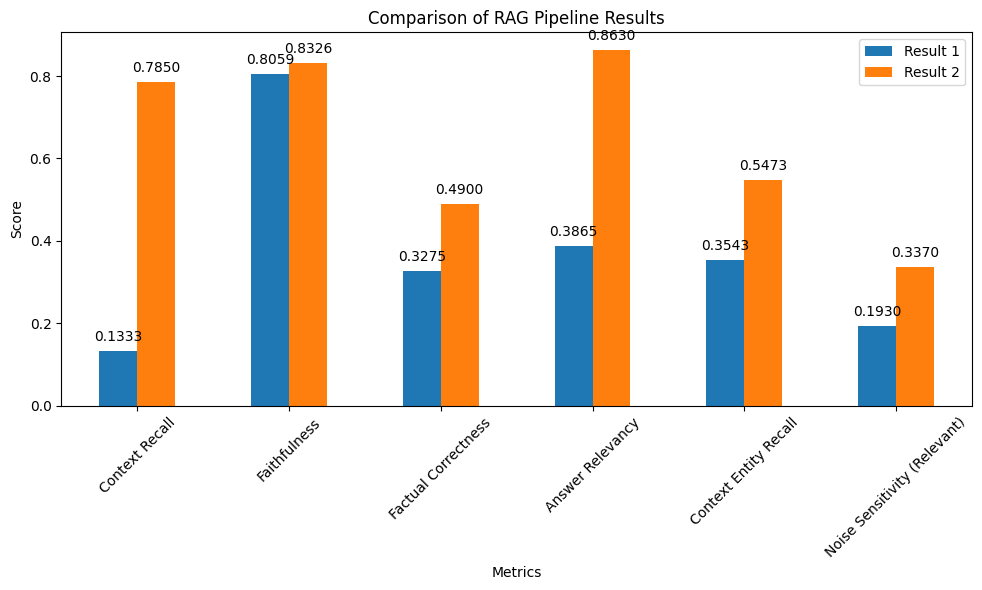

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Metric': ['Context Recall', 'Faithfulness', 'Factual Correctness', 'Answer Relevancy', 'Context Entity Recall', 'Noise Sensitivity (Relevant)'],
    'Result 1': [0.1333, 0.8059, 0.3275, 0.3865, 0.3543, 0.1930],
    'Result 2': [0.7850, 0.8326, 0.4900, 0.8630, 0.5473, 0.3370]
}

df = pd.DataFrame(data)
df = df.set_index('Metric')

# Plotting
ax = df.plot(kind='bar', figsize=(10, 6), rot=45)

# Add labels and title
plt.title('Comparison of RAG Pipeline Results')
plt.xlabel('Metrics')
plt.ylabel('Score')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

## Conclusion

Fine-tuning the embedding model resulted in significant improvements across all metrics.

Detailed Breakdown:

- Context Recall: Increased from 0.1333 to 0.7850. This substantial increase indicates that the fine-tuned model is significantly better at retrieving relevant context for the questions.

- Faithfulness: Increased from 0.8059 to 0.8326. This shows a slight improvement in the model's ability to generate answers that are grounded in the retrieved context, meaning the answers are more trustworthy and based on the provided information.

- Factual Correctness: Increased from 0.3275 to 0.4900.  This is a notable improvement in the factual accuracy of the generated answers, suggesting the fine-tuned model provides more correct information.

- Answer Relevancy: Increased dramatically from 0.3865 to 0.8630. This significant jump indicates that the fine-tuned model is much better at generating answers that are actually relevant and helpful to the user's questions.

- Context Entity Recall: Increased from 0.3543 to 0.5473. This improvement suggests that the fine-tuned model is better at recalling and utilizing key entities from the context when generating answers.

- Noise Sensitivity (Relevant): Increased from 0.1930 to 0.3370. This indicates that the fine-tuned model is more robust to noise in the relevant context and can still perform better even with potentially noisy information.

Overall Assessment:
Fine-tuning the embedding model led to a clear and substantial improvement in the RAG pipeline's performance across all measured metrics.  The fine-tuned model demonstrates significantly enhanced ability to retrieve relevant context, generate relevant and factually correct answers grounded in the provided context, and effectively utilize key information from the context. This makes the RAG system much more effective and reliable after fine-tuning.